In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

In [ ]:
!pip install gdown
!gdown 'https://drive.google.com/uc?id=1A0xoL44Yg68ixd-FuIJn2VC4vdZ6M2gn'
!unzip -q WildRF.zip

Downloading...
From (original): https://drive.google.com/uc?id=1A0xoL44Yg68ixd-FuIJn2VC4vdZ6M2gn
From (redirected): https://drive.google.com/uc?id=1A0xoL44Yg68ixd-FuIJn2VC4vdZ6M2gn&confirm=t&uuid=9db600d0-0d9d-467f-9537-76ddea1a95d3
To: /content/WildRF.zip
 47% 2.99G/6.40G [01:19<01:35, 35.9MB/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/response.py", line 873, in _raw_read
    data = self._fp_read(amt, read1=read1) if not fp_closed else b""
  File "/usr/local/lib/python3.10/dist-packages/urllib3/response.py", line 856, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
  File "/usr/lib/python3.10/http/client.py", line 466, in read
    s = self.fp.read(amt)
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.10/ssl.py", line 1303, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3.10/ssl.py", line 1159, in read
    

In [ ]:
np.random.seed(42)

In [ ]:
def get_req_set(path):
  df = pd.read_csv(path)
  features_df = df['features'].str.strip('[]').str.split(',', expand=True)
  features_df = features_df.astype(float)
  features_df.columns = [f'feature_{i}' for i in range(features_df.shape[1])]
  df_expanded = pd.concat([features_df, df['label']], axis=1)
  X = df_expanded.drop(columns=['label'])
  y = df_expanded['label']
  X_tensor = torch.tensor(X.values, dtype=torch.float32)
  y_tensor = torch.tensor(y.values, dtype=torch.long)
  dataset = TensorDataset(X_tensor, y_tensor)
  print(len(dataset))
  temp_loader = DataLoader(dataset, batch_size=32, shuffle=True)
  return temp_loader

In [ ]:
#JPEGS taken from all folders

In [ ]:
train_loader = get_req_set('/content/train_features.csv')
val_loader_1 = get_req_set('/content/facebook_features.csv')
val_loader_2 = get_req_set('/content/reddit_features.csv')
val_loader_3 = get_req_set('/content/twitter_features.csv')
val_loader_4 = get_req_set('/content/val_features.csv')

2712
320
1500
421
398


In [ ]:
class DNN(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim, dropout_prob=0.2):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.dropout2 = nn.Dropout(p=dropout_prob)
        self.fc3 = nn.Linear(hidden_dim_2, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


Epoch [1/10], Train Loss: 0.4120, Train Accuracy: 83.19%, Val Loss: 0.4064, Val Accuracy: 81.95%
Epoch [2/10], Train Loss: 0.2700, Train Accuracy: 89.38%, Val Loss: 0.3476, Val Accuracy: 86.22%
Epoch [3/10], Train Loss: 0.2400, Train Accuracy: 90.67%, Val Loss: 0.3216, Val Accuracy: 86.94%
Epoch [4/10], Train Loss: 0.2253, Train Accuracy: 91.26%, Val Loss: 0.3800, Val Accuracy: 83.85%
Epoch [5/10], Train Loss: 0.2160, Train Accuracy: 91.15%, Val Loss: 0.3781, Val Accuracy: 84.56%
Epoch [6/10], Train Loss: 0.1974, Train Accuracy: 92.18%, Val Loss: 0.2865, Val Accuracy: 87.17%
Epoch [7/10], Train Loss: 0.1857, Train Accuracy: 92.77%, Val Loss: 0.2841, Val Accuracy: 87.89%
Epoch [8/10], Train Loss: 0.1667, Train Accuracy: 93.47%, Val Loss: 0.4701, Val Accuracy: 79.81%
Epoch [9/10], Train Loss: 0.1694, Train Accuracy: 93.14%, Val Loss: 0.3514, Val Accuracy: 85.51%
Epoch [10/10], Train Loss: 0.1453, Train Accuracy: 94.65%, Val Loss: 0.3222, Val Accuracy: 86.94%


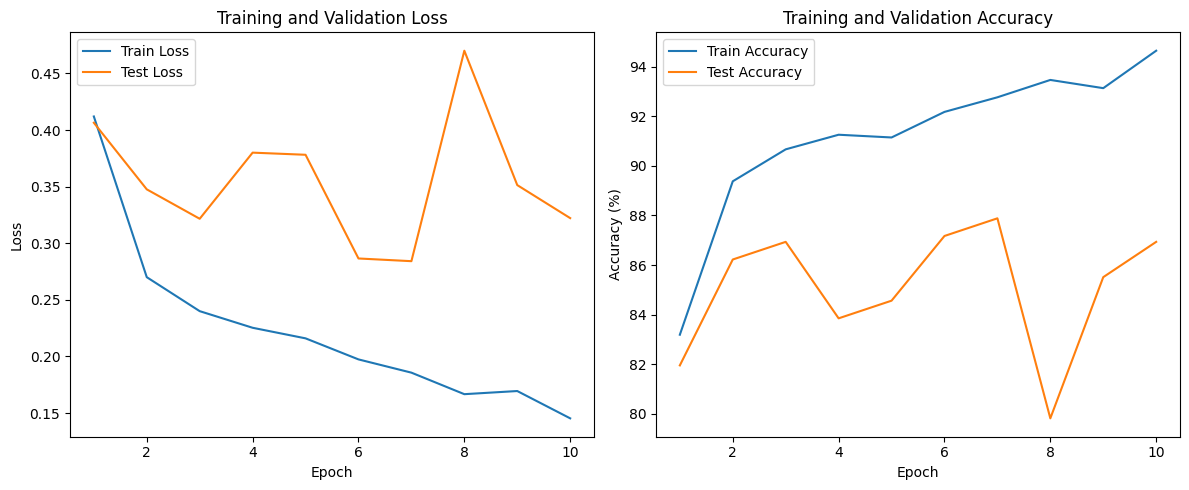

In [ ]:
input_dim = 768      # Number of features in the produced dataset
hidden_dim_1 = 128
hidden_dim_2 = 256
output_dim = 2 # Number of classes -- 2
model = DNN(input_dim, hidden_dim_1, hidden_dim_2, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == batch_y).sum().item()
        total_samples += batch_y.size(0)

    # Calculate train loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / total_samples * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on val data
    model.eval()
    test_loss = 0.0
    correct_test_predictions = 0
    total_test_samples = 0

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item()

            # Calculate val predictions and accuracy
            _, predicted = torch.max(outputs, 1)
            correct_test_predictions += (predicted == batch_y).sum().item()
            total_test_samples += batch_y.size(0)

    # Calculate test loss and accuracy
    test_loss /= len(val_loader)
    test_accuracy = correct_test_predictions / total_test_samples * 100
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {test_loss:.4f}, Val Accuracy: {test_accuracy:.2f}%")

# Plot training and testing accuracy and loss
plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Updated loop with four validation datasets and additional metrics
input_dim = 768      # Number of features in the produced dataset
hidden_dim_1 = 128
hidden_dim_2 = 256
output_dim = 2 # Number of classes -- 2
model = DNN(input_dim, hidden_dim_1, hidden_dim_2, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == batch_y).sum().item()
        total_samples += batch_y.size(0)

    # Calculate train loss and metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / total_samples * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on train data
    model.eval()
    with torch.no_grad():
        y_true_train = []
        y_pred_train = []
        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            y_true_train.extend(batch_y.cpu().numpy())
            y_pred_train.extend(predicted.cpu().numpy())

    # Calculate train metrics
    train_precision = precision_score(y_true_train, y_pred_train, average='binary')
    train_recall = recall_score(y_true_train, y_pred_train, average='binary')
    train_f1 = f1_score(y_true_train, y_pred_train, average='binary')

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Train Precision: {train_precision:.2f}, Train Recall: {train_recall:.2f}, Train F1: {train_f1:.2f}")

    # Validation loaders and names
    val_loaders = [val_loader_1, val_loader_2, val_loader_3, val_loader_4]
    val_names = ['Facebook', 'Reddit', 'Twitter', 'Validation']

    # Evaluate on each validation set
    for val_loader, val_name in zip(val_loaders, val_names):
        y_true_val = []
        y_pred_val = []
        val_loss = 0.0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                y_true_val.extend(batch_y.cpu().numpy())
                y_pred_val.extend(predicted.cpu().numpy())

        # Calculate metrics for each validation set
        val_loss /= len(val_loader)
        val_accuracy = accuracy_score(y_true_val, y_pred_val) * 100
        val_precision = precision_score(y_true_val, y_pred_val, average='binary')
        val_recall = recall_score(y_true_val, y_pred_val, average='binary')
        val_f1 = f1_score(y_true_val, y_pred_val, average='binary')

        print(f"{val_name} - "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, "
              f"Val Precision: {val_precision:.2f}, Val Recall: {val_recall:.2f}, Val F1: {val_f1:.2f}")

    print("------------------------------------------------")

Epoch [1/10], Train Loss: 0.4380, Train Accuracy: 79.24%, Train Precision: 0.93, Train Recall: 0.86, Train F1: 0.89
Facebook - Val Loss: 0.4088, Val Accuracy: 81.56%, Val Precision: 0.88, Val Recall: 0.73, Val F1: 0.80
Reddit - Val Loss: 0.2665, Val Accuracy: 89.73%, Val Precision: 0.92, Val Recall: 0.87, Val F1: 0.89
Twitter - Val Loss: 0.4028, Val Accuracy: 81.00%, Val Precision: 0.95, Val Recall: 0.75, Val F1: 0.84
Validation - Val Loss: 0.2804, Val Accuracy: 87.94%, Val Precision: 0.91, Val Recall: 0.84, Val F1: 0.87
------------------------------------------------
Epoch [2/10], Train Loss: 0.2688, Train Accuracy: 89.31%, Train Precision: 0.88, Train Recall: 0.94, Train F1: 0.91
Facebook - Val Loss: 0.3683, Val Accuracy: 81.88%, Val Precision: 0.78, Val Recall: 0.88, Val F1: 0.83
Reddit - Val Loss: 0.2472, Val Accuracy: 90.33%, Val Precision: 0.87, Val Recall: 0.94, Val F1: 0.91
Twitter - Val Loss: 0.3498, Val Accuracy: 85.75%, Val Precision: 0.92, Val Recall: 0.86, Val F1: 0.89
Va